In [ ]:
!pip install inference-sdk supervision ultralytics


In [ ]:
from inference_sdk import InferenceHTTPClient

CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="J7ODH4RBBwzdTdQNYJkQ"
)

result = CLIENT.infer('/content/men_full.jpg', model_id="main-fashion-wmyfk/1")

In [ ]:
result

{'inference_id': '1e82e8f7-1bce-4911-babc-3298c14c02dd',
 'time': 0.009040483999342541,
 'image': {'width': 183, 'height': 275},
 'predictions': [{'x': 74.5,
   'y': 96.0,
   'width': 77.0,
   'height': 66.0,
   'confidence': 0.8713505268096924,
   'class': 'shirt',
   'class_id': 4,
   'detection_id': '602133c3-6dcb-4d8f-8b72-d08df228906e'},
  {'x': 78.5,
   'y': 194.5,
   'width': 43.0,
   'height': 135.0,
   'confidence': 0.6948529481887817,
   'class': 'pants',
   'class_id': 3,
   'detection_id': '186da6e8-1e23-48e7-ba19-76d8f7cf373f'}]}

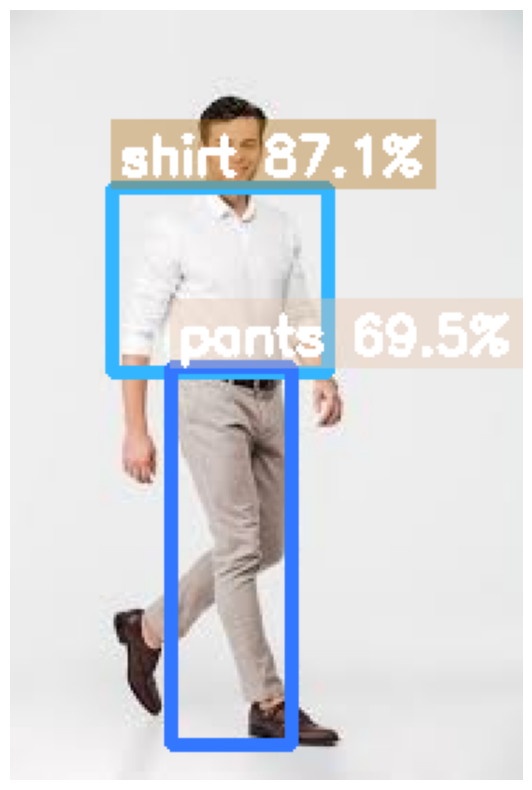

In [ ]:
import cv2
import supervision as sv
import numpy as np
import matplotlib.pyplot as plt

def draw_bounding_boxes(image_path, detection_results):
    """
    Draws polished bounding boxes with semi-transparent label backgrounds.
    """

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    predictions = detection_results["predictions"]

    # xyxy format
    xyxy = np.array([
        [
            pred["x"] - pred["width"] / 2,   # x_min
            pred["y"] - pred["height"] / 2,  # y_min
            pred["x"] + pred["width"] / 2,   # x_max
            pred["y"] + pred["height"] / 2   # y_max
        ]
        for pred in predictions
    ])

    detections = sv.Detections(
        xyxy=xyxy,
        confidence=np.array([pred["confidence"] for pred in predictions]),
        class_id=np.array([pred["class_id"] for pred in predictions])
    )

    labels = [
        f"{pred['class']} {pred['confidence']*100:.1f}%"
        for pred in predictions
    ]

    # Colors (BGR int tuples)
    cmap = plt.get_cmap("tab20")
    colors = [
        tuple(int(c*255) for c in cmap(i % 20)[:3][::-1])
        for i in range(len(predictions))
    ]

    # Draw boxes
    box_annotator = sv.BoxAnnotator(thickness=3)
    annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections)

    # Draw semi-transparent text boxes
    for i, (x_min, y_min, _, _) in enumerate(xyxy):
        label = labels[i]
        color = colors[i]

        # Text size
        (tw, th), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)

        # Rectangle coords
        x1, y1 = int(x_min), int(y_min) - th - baseline - 4
        x2, y2 = int(x_min) + tw + 6, int(y_min)

        # Ensure bounds
        x1, y1 = max(x1, 0), max(y1, 0)

        # Overlay for transparency
        overlay = annotated_image.copy()
        cv2.rectangle(overlay, (x1, y1), (x2, y2), color, -1)

        # Add transparency (0.4 = 40%)
        cv2.addWeighted(overlay, 0.4, annotated_image, 0.6, 0, annotated_image)

        # Put text
        cv2.putText(
            annotated_image,
            label,
            (x1 + 3, y2 - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 255, 255),
            2
        )

    plt.figure(figsize=(10, 10))
    plt.imshow(annotated_image)
    plt.axis("off")
    plt.show()




# Usage
draw_bounding_boxes("/content/men_full.jpg", result)


In [ ]:
result = CLIENT.infer('/content/men-full_2.jpg', model_id="main-fashion-wmyfk/1")

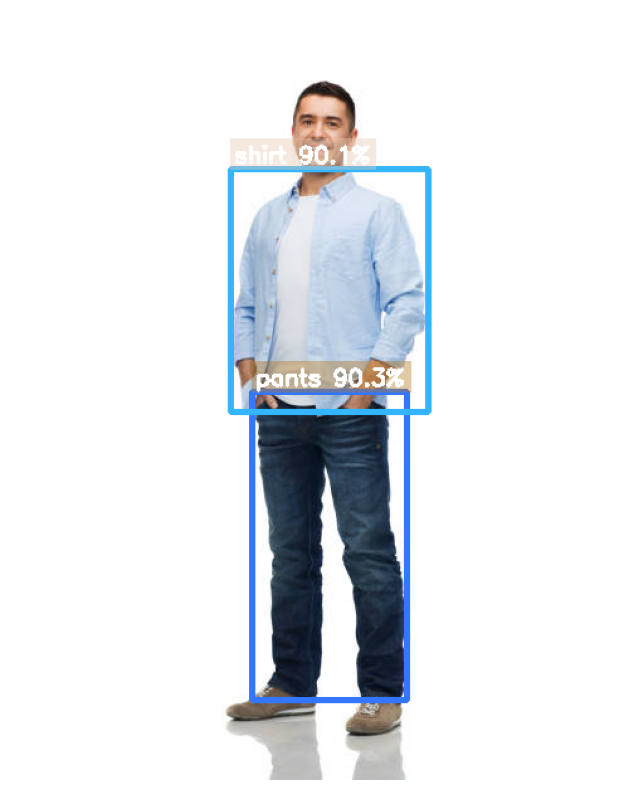

In [ ]:
# Usage
draw_bounding_boxes("/content/men-full_2.jpg", result)

In [ ]:
from ultralytics import SAM

# Load a model
model = SAM("sam2.1_b.pt")

# Display model information (optional)
model.info()

Model summary: 403 layers, 80,850,178 parameters, 80,850,178 gradients


(403, 80850178, 80850178, 0.0)

In [ ]:
def extract_bboxes(detection_results):
    """
    Extracts bounding boxes from detection results in [x_min, y_min, x_max, y_max] format.
    """
    predictions = detection_results["predictions"]

    bboxes = [
        [
            int(pred["x"] - pred["width"] / 2),   # x_min
            int(pred["y"] - pred["height"] / 2),  # y_min
            int(pred["x"] + pred["width"] / 2),   # x_max
            int(pred["y"] + pred["height"] / 2)   # y_max
        ]
        for pred in predictions
    ]
    return bboxes


In [ ]:
result

{'inference_id': '2b2493f5-6275-41d0-805b-688c6eb0c404',
 'time': 0.013186540003516711,
 'image': {'width': 476, 'height': 612},
 'predictions': [{'x': 253.5,
   'y': 425.5,
   'width': 123.0,
   'height': 245.0,
   'confidence': 0.9026530981063843,
   'class': 'pants',
   'class_id': 3,
   'detection_id': 'd0d3cad3-c10d-414f-9504-932ca89a33f3'},
  {'x': 253.5,
   'y': 222.5,
   'width': 157.0,
   'height': 193.0,
   'confidence': 0.901165783405304,
   'class': 'shirt',
   'class_id': 4,
   'detection_id': 'bbfde588-f671-4013-b537-c014634077a7'}]}

In [ ]:
# Get bounding boxes from result
bboxes = extract_bboxes(result)

In [ ]:
bboxes

[[192, 303, 315, 548], [175, 126, 332, 319]]

In [ ]:
# Run inference with bboxes prompt
segment_result = model("/content/men-full_2.jpg", bboxes=bboxes[1])


image 1/1 /content/men-full_2.jpg: 1024x1024 1 0, 20561.0ms
Speed: 73.0ms preprocess, 20561.0ms inference, 4.0ms postprocess per image at shape (1, 3, 1024, 1024)


In [ ]:
segment_result

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: '0'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
  

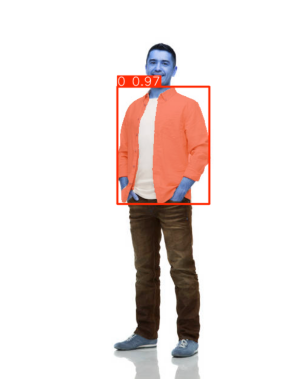

In [ ]:
# Assuming `segment_result` is your output
segmented_img = segment_result[0].plot()   # returns numpy array with overlays

plt.imshow(segmented_img)
plt.axis("off")
plt.show()


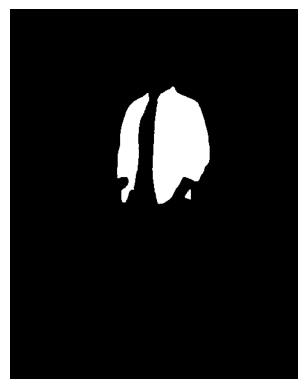

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def save_binary_masks(segment_result, save_dir="masks"):
    """
    Saves binary masks (white object, black background) for each detected object.
    """
    masks = segment_result[0].masks.data.cpu().numpy()  # (N, H, W)

    for i, mask in enumerate(masks):
        binary_mask = (mask > 0.5).astype(np.uint8) * 255  # convert to 0/255

        # Save as PNG
        cv2.imwrite(f"{save_dir}/mask_{i}.png", binary_mask)

        # Optional: show one
        if i == 0:
            plt.imshow(binary_mask, cmap="gray")
            plt.axis("off")
            plt.show()

# Usage
save_binary_masks(segment_result)


In [ ]:
# Run inference with bboxes prompt
segment_result = model("/content/men-full_2.jpg", bboxes=bboxes[0])


image 1/1 /content/men-full_2.jpg: 1024x1024 1 0, 18046.1ms
Speed: 10.6ms preprocess, 18046.1ms inference, 3.5ms postprocess per image at shape (1, 3, 1024, 1024)


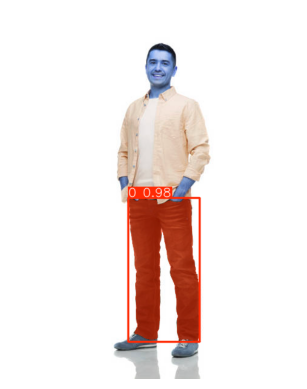

In [ ]:
# Assuming `segment_result` is your output
segmented_img = segment_result[0].plot()   # returns numpy array with overlays

plt.imshow(segmented_img)
plt.axis("off")
plt.show()


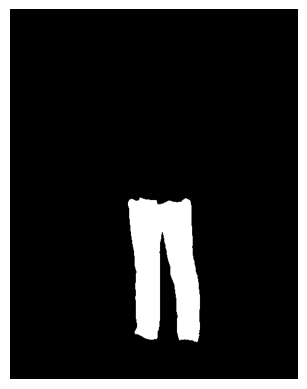

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def save_binary_masks(segment_result, save_dir="masks"):
    """
    Saves binary masks (white object, black background) for each detected object.
    """
    masks = segment_result[0].masks.data.cpu().numpy()  # (N, H, W)

    for i, mask in enumerate(masks):
        binary_mask = (mask > 0.5).astype(np.uint8) * 255  # convert to 0/255

        # Save as PNG
        cv2.imwrite(f"{save_dir}/mask_{i}.png", binary_mask)

        # Optional: show one
        if i == 0:
            plt.imshow(binary_mask, cmap="gray")
            plt.axis("off")
            plt.show()

# Usage
save_binary_masks(segment_result)


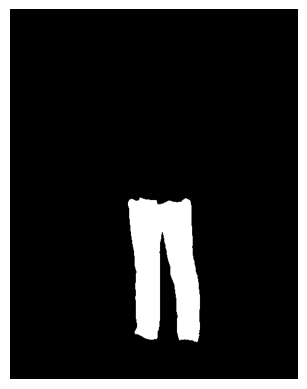

In [ ]:
save_binary_masks(segment_result, save_dir="/content/")

## Inpainting

In [ ]:
import requests
import base64

# Use this function to convert an image file from the filesystem to base64
def image_file_to_base64(image_path):
    with open(image_path, 'rb') as f:
        image_data = f.read()
    return base64.b64encode(image_data).decode('utf-8')

# Use this function to fetch an image from a URL and convert it to base64
def image_url_to_base64(image_url):
    response = requests.get(image_url)
    image_data = response.content
    return base64.b64encode(image_data).decode('utf-8')

# Use this function to convert a list of image URLs to base64
def image_urls_to_base64(image_urls):
    return [image_url_to_base64(url) for url in image_urls]

api_key = "SG_99948c485eee0992"
url = "https://api.segmind.com/v1/sdxl-inpaint"

# Request payload
data = {
  "image": image_file_to_base64("/content/men-full_2.jpg"),  # Or use image_file_to_base64("IMAGE_PATH")
  "mask": image_file_to_base64("/content/mask_0.png"),  # Or use image_file_to_base64("IMAGE_PATH")
  "prompt": "A green Jeans",
  "negative_prompt": "bad quality, painting, blur",
  "samples": 1,
  "scheduler": "DDIM",
  "num_inference_steps": 25,
  "guidance_scale": 7.5,
  "seed": 12467,
  "strength": 0.9,
  "base64": False
}

headers = {'x-api-key': api_key}

response = requests.post(url, json=data, headers=headers)
print(response.content)  # The response is the generated image

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc2\x00\x11\x08\x02h\x01\xe0\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1d\x00\x01\x01\x00\x01\x05\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x05\x03\x04\x06\x07\x08\t\x01\xff\xc4\x00\x1a\x01\x01\x00\x02\x03\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x01\xf7\xc3Q)\xa9\xa15"\xa4P\x82jd\x12T\xa1I\xa8MMI5"\xa4*EHT\xd2\x00\x00\x02hH\xb0\n\x9aT\x04\xd0\x00\x00\x00MP\x9a\t\x99\xa9REM \x02jd\x12\x00\x00\x155\x

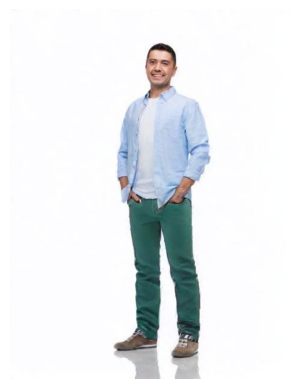

In [ ]:
from PIL import Image
import io
import matplotlib.pyplot as plt

# Assuming 'response' variable from the previous cell exists and contains the image bytes
image_bytes = response.content

# Use io.BytesIO to treat the byte string as a file
image_stream = io.BytesIO(image_bytes)

# Open the image using PIL
image = Image.open(image_stream)

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off') # Hide axes
plt.show()